# Write a custom transpiler pass

The Qiskit SDK lets you create custom transpilation passes and run them in the `PassManager` object or add them to a `StagedPassManager`. Here we will demonstrate how to write a  transpiler pass, focusing on building a pass that performs [Pauli twirling](https://arxiv.org/abs/quant-ph/0606161) on the noisy quantum gates in a quantum circuit. This example uses the DAG, which is the object manipulated by the `TransformationPass` type of pass.

<details>
  <summary>
    Background: DAG representation
  </summary>

Before building a pass, it is important to introduce the internal representation of quantum circuits in Qiskit, the [directed acyclic graph (DAG)](../api/qiskit/qiskit.dagcircuit.DAGCircuit) (see [this tutorial](https://qiskit.org/ecosystem/rustworkx/tutorial/dags.html) for an overview).  To follow these steps, install the [`graphviz` library](https://graphviz.org/download/) for the DAG plotting functions.

In Qiskit, within the transpilation stages, circuits are represented using a DAG.  In general, a DAG is composed of *vertices* (also known as "nodes") and directed *edges* that connect pairs of vertices in a particular orientation.  This representation is stored using `qiskit.dagcircuit.DAGCircuit` objects that are composed of invididual `DagNode` objects.  The advantage of this representation over a pure list of gates (that is, a *netlist*) is that the flow of information between operations is explicit, making it easier to make transformation decisions.

This example illustrates the DAG by creating a simple circuit that prepares a Bell state and applies an $R_Z$ rotation, depending on the measurement outcome.

```python
  from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
  import numpy as np

  qr = QuantumRegister(3, 'qr')
  cr = ClassicalRegister(3, 'cr')
  qc = QuantumCircuit(qr, cr)

  qc.h(qr[0])
  qc.cx(qr[0], qr[1])
  qc.measure(qr[0], cr[0])
  qc.rz(np.pi/2, qr[1]).c_if(cr, 2)
  qc.draw(output='mpl')

```
![The circuit's DAG consists of nodes that are connected by directional edges. It is a visual way to represent qubits or classical bits, the operations, and the way that data flows. ](/images/guides/custom-transpiler-pass/DAG_circ.png "DAG")

Use the `qiskit.tools.visualization.dag_drawer()` function to view this circuit's DAG.  There are three kinds of graph nodes: qubit/clbit nodes (green), operation nodes (blue), and output nodes (red).  Each edge indicates data flow (or dependency) between two nodes.

```python
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer

dag = circuit_to_dag(qc)
dag_drawer(dag)
```
![](/images/guides/custom-transpiler-pass/DAG.png)
</details>

## Transpiler passes

Transpiler passes are classified either as an [`AnalysisPass`](../api/qiskit/qiskit.transpiler.AnalysisPass) or a [`TransformationPass`](../api/qiskit/qiskit.transpiler.TransformationPass). Passes in general work with the [DAG](../api/qiskit/qiskit.dagcircuit.DAGCircuit) and the `property_set`, a dictionary-like object for storing properties determined by analysis passes. Analysis passes work with both the DAG and its `property_set`.  They cannot modify the DAG, but can modify the `property_set`.  This contrasts with transformation passes, which do modify the DAG, and can read (but not write to) `property_set`.  For example, transformation passes translate a circuit to its [ISA](./transpile#instruction-set-architecture) or perform routing passes to insert SWAP gates where needed.

## Create a `PauliTwirl` transpiler pass

The following example constructs a transpiler pass that adds Pauli twirls. [Pauli twirling](https://arxiv.org/abs/quant-ph/0606161) is an error suppression strategy that randomizes how qubits experience noisy channels, which we assume to be two-qubit gates in this example (because they are much more error-prone than single-qubit gates). The Pauli twirls do not affect the two-qubit gates' operation. They are chosen such that those applied *before* the two-qubit gate (to the left) are countered by those applied *after* the two-qubit gate (to the right). In this sense, the two-qubit operations are identical, but the way they are performed is different. One benefit of Pauli twirling is that it turns coherent errors into stochastic errors, which can be improved by averaging more.

Transpiler passes act on the [DAG](../api/qiskit/qiskit.dagcircuit.DAGCircuit), so the important method to override is `.run()`, which takes the DAG as input. Initializing pairs of Paulis as shown preserves the operation of each two-qubit gate. This is done with the helper method `build_twirl_set`, which goes through each two-qubit Pauli (as obtained from `pauli_basis(2)`) and finds the other Pauli that preserves the operation.

From the DAG, use the `op_nodes()` method to return all of its nodes. The DAG can also be used to collect runs, which are sequences of nodes that run uninterrupted on a qubit. These can be collected as single-qubit runs with `collect_1q_runs`, two-qubit runs with `collect_2q_runs`, and runs of nodes where the instruction names are in a namelist with `collect_runs`.  The `DAGCircuit` has many methods for searching and traversing a graph.  One commonly used method is `topological_op_nodes`, which provides the nodes in a dependency ordering. Other methods such as `bfs_successors` are used primarily to determine how nodes interact with subsequent operations on a DAG.

In the example, we want to replace each node, representing an instruction, with a subcircuit built as a mini DAG. The mini DAG has a two-qubit quantum register added to it.  Operations are added to the mini DAG by using `apply_operation_back`, which places the `Instruction` on the mini DAG's output (whereas `apply_operation_front` would place it on the mini DAG's input). The node is then substituted by the mini DAG by using `substitute_node_with_dag`, and the process continues over each instance of `CXGate` and `ECRGate` in the DAG (corresponding to the two-qubit basis gates on IBM&reg; backends).

In [1]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis

import numpy as np

from typing import Iterable, Optional

In [2]:
class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""

    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates, `cx` and `ecr` for IBM backends.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()

    def build_twirl_set(self):
        """
        Build a set of Paulis to twirl for each gate and store internally as .twirl_set.
        """
        self.twirl_set = {}

        # iterate through gates to be twirled
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []

            # iterate through Paulis on left of gate to twirl
            for pauli_left in pauli_basis(2):

                # iterature through Paulis on right of gate to twirl
                for pauli_right in pauli_basis(2):

                    # save pairs that produce identical operation as gate to twirl
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(Operator(twirl_gate) @ pauli_right):
                        twirl_list.append((pauli_left, pauli_right))

            self.twirl_set[twirl_gate.name] = twirl_list

    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:

        # collect all nodes in DAG and proceed if it is to be twirled
        twirling_gate_classes = tuple(gate.base_class for gate in self.gates_to_twirl)
        for node in dag.op_nodes():
            if not isinstance(node.op, twirling_gate_classes):
                continue

            # random integer to select Pauli twirl pair
            pidx = np.random.randint(0, len(self.twirl_set[node.op.name]),)
            twirl_pair = self.twirl_set[node.op.name][pidx]

            # instantiate mini_dag and attach quantum register
            mini_dag = DAGCircuit()
            register = QuantumRegister(2)
            mini_dag.add_qreg(register)

            # apply left Pauli, gate to twirl, and right Pauli to empty mini-DAG
            mini_dag.apply_operation_back(twirl_pair[0].to_instruction(), [register[0], register[1]])
            mini_dag.apply_operation_back(node.op, [register[0], register[1]])
            mini_dag.apply_operation_back(twirl_pair[1].to_instruction(), [register[0], register[1]])

            # substitute gate to twirl node with twirling mini-DAG
            dag.substitute_node_with_dag(node, mini_dag)

        return dag

## Use the `PauliTwirl` transpiler pass

The following code uses the pass created above to transpile a circuit. Consider a simple circuit with `cx`s and `ecr`s.

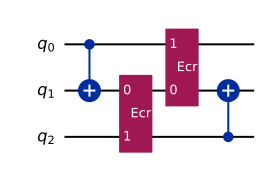

In [3]:
qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.ecr(1, 2)
qc.ecr(1, 0)
qc.cx(2, 1)
qc.draw('mpl')

To apply the custom pass, build a pass manager using the `PauliTwirl` pass and run it on 50 circuits.

In [4]:
pm = PassManager([PauliTwirl()])
twirled_qcs = [pm.run(qc) for _ in range(50)]

Each two-qubit gate is now sandwiched between two Paulis.

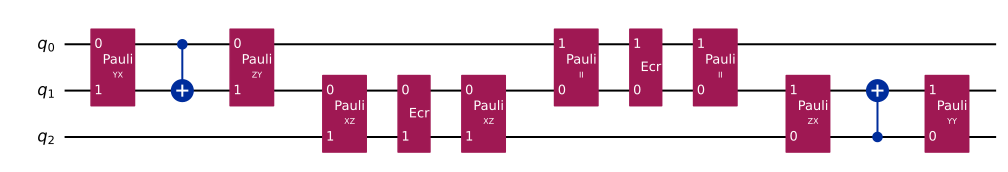

In [5]:
twirled_qcs[-1].draw('mpl')

The operators are the same if `Operator` from `qiskit.quantum_info` is used:

In [6]:
np.all([Operator(twirled_qc).equiv(qc) for twirled_qc in twirled_qcs])

np.True_

## Next steps

<Admonition type="tip" title="Recommendations">
    - To learn how to use the `transpile` function, start with the [Transpilation default settings and configuration options](defaults-and-configuration-options) topic.
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - Review the [Transpile API documentation.](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler)
</Admonition>